<a href="https://colab.research.google.com/github/jngeo/Google-Colab-Notebooks/blob/master/Example_3_GPLVM_on_Tensorflow_Probabilities_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Gaussian Process Latent Variable Model (GPLVM)

- testing this example
- original source: [here](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Latent_Variable_Model.ipynb)



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk
%pylab inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


In [0]:
def reset_session():
  """Creates a new global, interactive session in Graph-mode."""
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

reset_session()

### Load MNIST Data

In [3]:
# Load the MNIST data set and isolate a subset of it.
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
print('Number of Images: ', N)
print('shape of small_x_train: ', np.shape(small_x_train))
print('shape of small_y_train: ', np.shape(small_y_train))
small_y_train[0:10]

Number of Images:  1000
shape of small_x_train:  (1000, 28, 28)
shape of small_y_train:  (1000,)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [24]:
#np.shape(small_x_train[0:100,:,:])
np.shape(small_x_train[0,:,:])

(28, 28)

(100, 28, 28)
(10, 10, 28, 28)
(10, 28, 10, 28)
(280, 280)


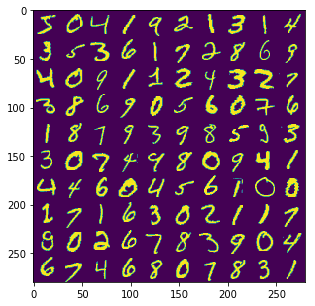

In [32]:
img_ = np.squeeze(small_x_train[0:100,:,:])
print(np.shape(img_))
img_ = img_.reshape(10, 10, 28, 28)
print(np.shape(img_))
img_ = img_.transpose([0, 2, 1, 3])
print(np.shape(img_))
img_ = img_.reshape(28 * 10, 28 * 10)
print(np.shape(img_))

plt.figure(figsize=(5, 5))
plt.imshow(img_,interpolation='none')
plt.show()

In [7]:
# We'll be jointly training 3 model parameters as well as the latent inputs.
# Create some trainable model parameters. We also constrain them to be strictly
# positive

amplitude = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='amplitude',
                    dtype=tf.float64,
                    initializer=np.float64(1.)))

length_scale = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='length_scale',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

observation_noise_variance = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='observation_noise_variance',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()
print('flatten img observations: ', np.shape(observations_))


flatten img observations:  (784, 1000)


In [0]:
# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. 

init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.get_variable(
    name='latent_index_points',
    dtype=tf.float64,
    initializer=init_)

In [40]:
print(np.shape(init_))
print(np.shape(latent_index_points))

(1000, 2)
(1000, 2)


### Construct GPLVM Model



In [15]:
# Create our kernel and GP distribution
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=latent_index_points,
    observation_noise_variance=observation_noise_variance)

# Compute the log probability density of each of the observations. This is what
# we will maximize below.
log_probs = gp.log_prob(observations_, name='log_prob')

# Our training loss is the negative log likelihood of the observations. Since
# the observations are IID, the log likelihoods are summed. We normalize the sum
# (take the average) to reduce the risk of extreme values subject to floating
# point issues.
loss = -tf.reduce_mean(log_probs)
optimizer = tf.train.AdamOptimizer(learning_rate=.1)
train_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


### Predictive Model

In [17]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)
np.shape(grid_)

(10, 10, 2)

In [0]:
# This part's a bit subtle! What we defined above was a batch of 784 (=28x28)
# independent GP distributions over the input space. Each one corresponds to a
# single pixel of an MNIST image. Now what we'd like to do is draw 100 (=10x10)
# *independent* samples, each one separately conditioned on all the observations
# as well as the learned latent input locations above.
#
# The GP regression model below will define a batch of 784 independent
# posteriors. We'd like to get 100 independent samples each at a different
# latent index point. We could loop over the points in the grid, but that might
# be a bit slow. Instead, we can vectorize the computation by tacking on *even
# more* batch dimensions to our GaussianProcessRegressionModel distribution.
# In the below grid_ shape, we have concatentaed
#   1. batch shape: [sample_grid_points, sample_grid_points, 1]
#   2. number of examples: [1]
#   3. number of latent input dimensions: [2]
# The `1` in the batch shape will broadcast with 784. The final result will be
# samples of shape [10, 10, 784, 1]. The `1` comes from the "number of examples"
# and we can just `np.squeeze` it off.
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=grid_,
    observation_index_points=latent_index_points,
    observations=observations_)

# Create a sample operation in the graph.
samples = gprm.sample()

### Train and plot the resulting latent embeddings

In [34]:
# Initialize variables and train!
sess.run(tf.global_variables_initializer())
num_iters = 100
log_interval = 20
lips_ = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
  _, loss_, lips_[i] = sess.run([train_op, loss, latent_index_points])
  if i % log_interval == 0 or i + 1 == num_iters:
    print("Loss at step %d: %f" % (i, loss_))

Loss at step 0: 1107.881972
Loss at step 20: 422.587083
Loss at step 40: -115.266909
Loss at step 60: -227.014720
Loss at step 80: -253.574176
Loss at step 99: -259.975018


In [41]:
### 
print('shape of init_',np.shape(init_))
print('shape of lips_', np.shape(lips_))

shape of init_ (1000, 2)
shape of lips_ (100, 1000, 2)


### Plot Results

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


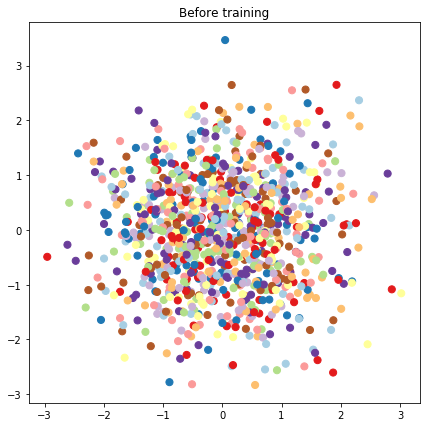

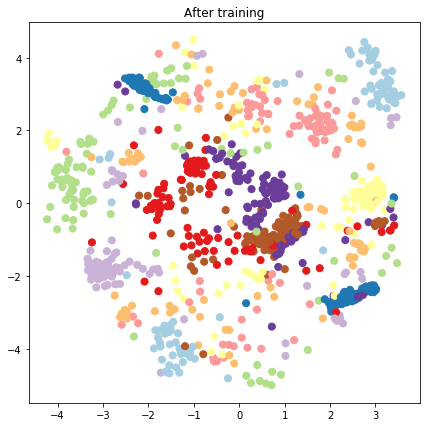

In [38]:
# Plot the latent locations before and after training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid('off')
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid('off')
plt.scatter(x=lips_[-1, :, 0], y=lips_[-1, :, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

### Draw samples conditioned on the data and latent embeddings


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


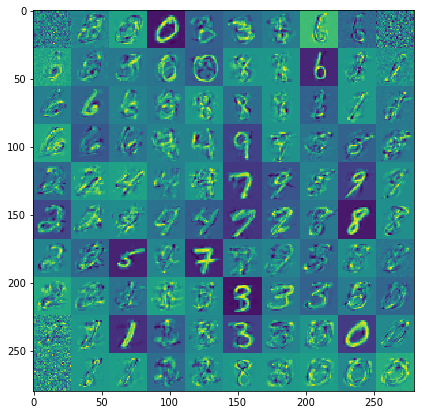

In [48]:
samples_ = sess.run(samples)

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples_)
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)

plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid('off')
ax.imshow(samples_, interpolation='none')#, cmap='Greys')
plt.show()

### PCA initialized

In [56]:
# PCA-initialize this time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_components = 2
pca = PCA(n_components=pca_components)

### normalize/standardize
scx = StandardScaler()
observations_norm_ = scx.fit_transform(observations_.transpose())
print('shape of observations_norm_: ', np.shape(observations_norm_))

### pca
observations_pca_ = pca.fit_transform(observations_norm_)
print('shape of pca_reduced: ', np.shape(observations_pca_))


init_pca_ = observations_pca_
latent_indexpca_points = tf.get_variable(
    name='latent_indexpca_points',
    dtype=tf.float64,
    initializer=init_pca_)

shape of observations_norm_:  (1000, 784)
shape of pca_reduced:  (1000, 2)


In [0]:
### create gplvm model for PCA

kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=latent_indexpca_points,
    observation_noise_variance=observation_noise_variance)

# Compute the log probability density of each of the observations. This is what
# we will maximize below.
log_probs = gp.log_prob(observations_, name='log_prob')

# Our training loss is the negative log likelihood of the observations. Since
# the observations are IID, the log likelihoods are summed. We normalize the sum
# (take the average) to reduce the risk of extreme values subject to floating
# point issues.
loss = -tf.reduce_mean(log_probs)
optimizer = tf.train.AdamOptimizer(learning_rate=.1)
train_op = optimizer.minimize(loss)


In [57]:
latent_indexpca_points

<tf.Variable 'latent_indexpca_points:0' shape=(1000, 2) dtype=float64_ref>

In [60]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)
np.shape(grid_)

(10, 10, 2)

In [0]:
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=grid_,
    observation_index_points=latent_indexpca_points,
    observations=observations_)

# Create a sample operation in the graph.
samples = gprm.sample()

In [62]:
# Initialize variables and train!
sess.run(tf.global_variables_initializer())
num_iters = 100
log_interval = 20
lips_ = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
  _, loss_, lips_[i] = sess.run([train_op, loss, latent_indexpca_points])
  if i % log_interval == 0 or i + 1 == num_iters:
    print("Loss at step %d: %f" % (i, loss_))

Loss at step 0: 1227.556219
Loss at step 20: 438.598808
Loss at step 40: -121.604557
Loss at step 60: -208.173045
Loss at step 80: -243.762413
Loss at step 99: -263.800304


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


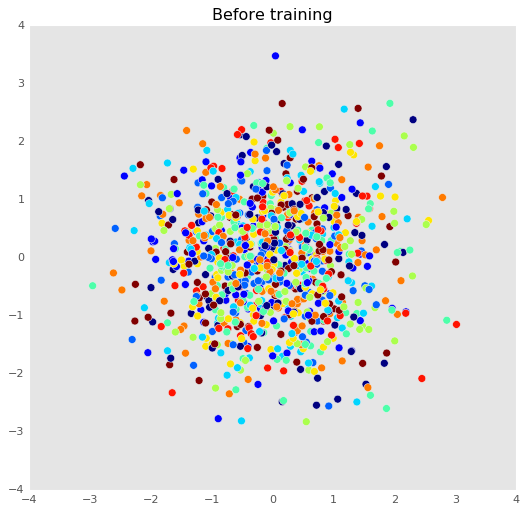

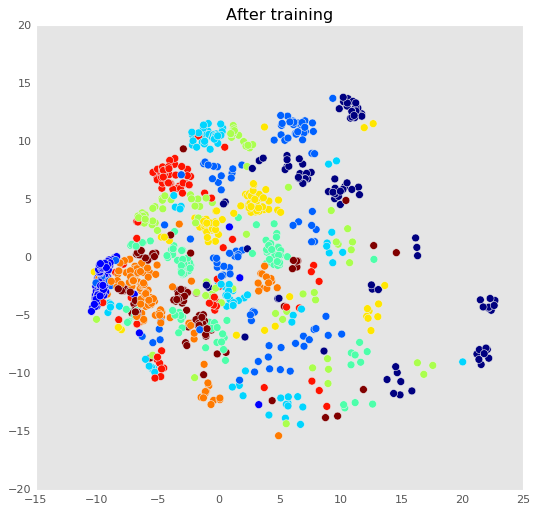

In [69]:
plt.style.use('ggplot')

# Plot the latent locations before and after training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid('off')
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], s=50)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid('off')
plt.scatter(x=lips_[-1, :, 0], y=lips_[-1, :, 1],
           c=y_train[:N], s=50)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


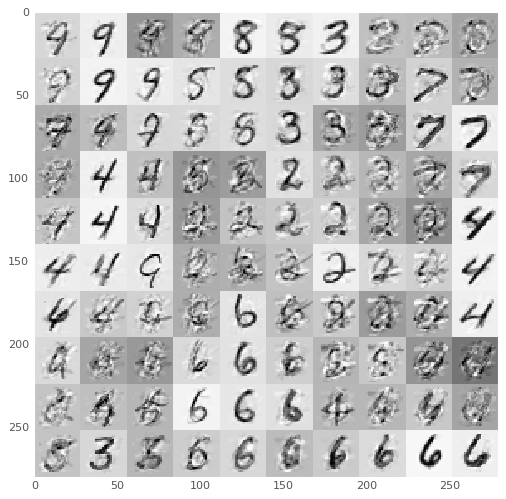

In [71]:
samples_ = sess.run(samples)

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples_)
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)

plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid('off')
ax.imshow(samples_, interpolation='none', cmap='Greys')
plt.show()